Ising with nearest-neighbor interactions

Assign energies to each state.

States: 
- closed, adjacent closed (zero energy)
    - 1 adjacent up (x2?)
    - 2 adjacent up
- open, adjacent closed ($\epsilon$ energy)
    - 1 adjacent up
    - 2 adjacent up

All closed is minimum energy. Low energy is higher probability? At what temp does it work out at?

Partition function of one state:

$$
Z = \sum_s e^{-\epsilon_s/\tau} \\
\epsilon_{0,0} = 0 \\
\epsilon_{0,1} = a \\ %not sure what these are yet
\epsilon_{0,2} = b \\
\epsilon_{1,0} = \epsilon + c\\
\epsilon_{1,1} = \epsilon + d \\
\epsilon_{1,2} = \epsilon \\

P(s,n) = \frac{e^{-\epsilon_{s,n}/\tau}}{e^{-\epsilon_{0,n}} + e^{-\epsilon_{1,n}}} \\
$$

Really there is only two states, but state energy updates each round. We'll use a markov chain to monitor these.

Edges: use open vals

0.9900990099009904
0.6195460776846916
0.6382447255714583
0.5817214864343576
0.642058693781466
0.6234350402073174
0.5877880535306277
0.5043622911741723
0.603011008793187
0.5481986923967122


<Axes: >

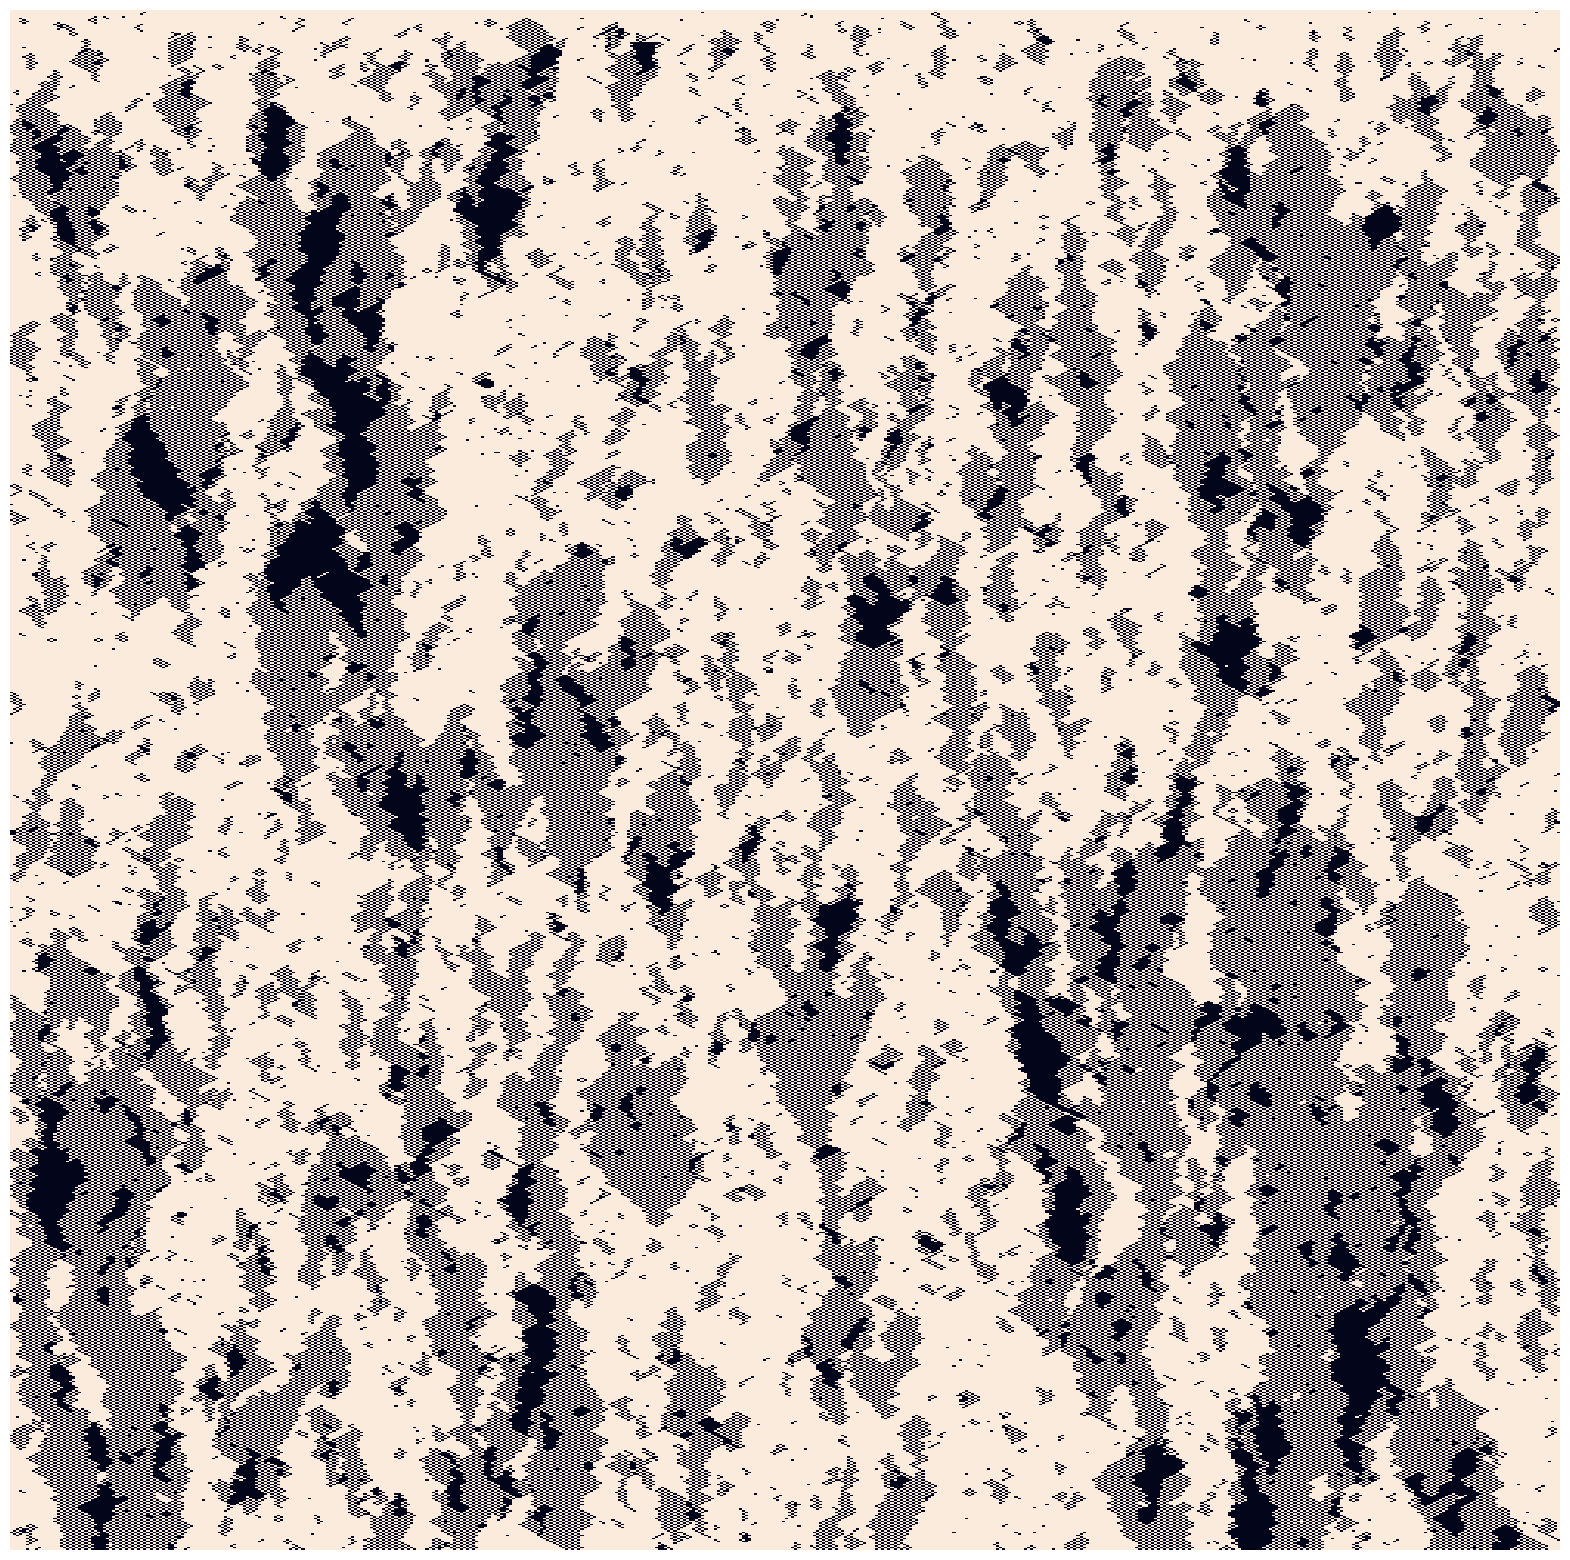

In [233]:
import numpy as np
from numpy import exp
from scipy.constants import k
import seaborn as sns
import matplotlib.pyplot as plt

#Temp = 20 # °C
#tau = k*(Temp + 273.15)
tau=10
a = 1
b = 2
c = 2
d = 1
epsilon = 10
#
#Z_table = np.array([
#    [1, exp(-a/tau), exp(-b/tau)],
#    [exp(-(epsilon+c)/tau), exp(-(epsilon+d)/tau), exp(epsilon/tau)]
#])

Z_table = np.array([
    [1000, 1, 1],
    [1, 1.2, 100]
])

n = 500 #chain length
chain = np.ones(n, dtype=int)
neighbors = np.zeros(n, dtype=int)
chain_list = [chain.copy()]

for i in range(1000):

    
    neighbors[1:-1] = chain[2:] + chain[:-2]
    neighbors[0] = 1 + chain[1]
    neighbors[-1] = 1 + chain[-2]

    probability_threshold = Z_table[chain, neighbors] / Z_table.sum(axis=0)[neighbors] # probability to stayin current state
    if i % 100 == 0:
        print(probability_threshold.mean())
    state_change = np.random.rand(n)>probability_threshold
    chain[state_change] = 1-chain[state_change]

    if i == 20:
        chain[200:210] = 0

    chain_list.append(chain.copy())

plt.figure(figsize=(20,20))
sns.heatmap(np.array(chain_list), xticklabels=False, yticklabels=False, cbar=False)

<Axes: >

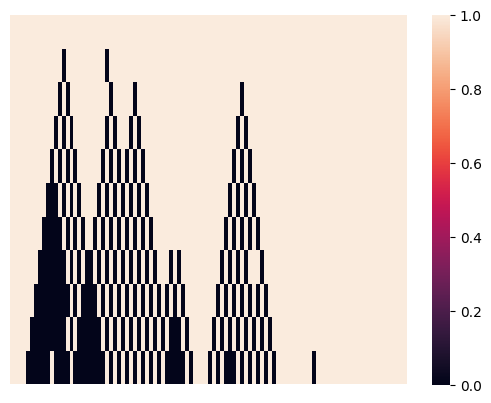

# other stuff

---

In [30]:
import cirq

# Define two qubits
q0 = cirq.LineQubit(0)
q1 = cirq.LineQubit(1)

# Define the |01> state
initial_state = [0, 1, 0, 0]  # |01>

# Define the XX + YY operator using Cirq's PauliString
xx = cirq.PauliString(cirq.X(q0) * cirq.X(q1))
yy = cirq.PauliString(cirq.Y(q0) * cirq.Y(q1))

# Combine XX + YY
operator = xx + yy

# Create a circuit to apply the operator
circuit = cirq.Circuit()

# Prepare the initial state |01> using single-qubit gates
circuit.append(cirq.X(q1))  # Flip q0 to |1> (now |01>)

circuit.append(operator)

## Add the XX + YY operator as a gate
#circuit.append(cirq.PauliSumExponential(operator, exponent=1.0))
#
# Simulate the circuit
simulator = cirq.Simulator()
result = simulator.simulate(circuit, initial_state=initial_state)

# Print the final state vector
print("Final state vector after applying XX + YY:")
print(result.final_state_vector)

Final state vector after applying XX + YY:
[-1.+0.j  0.+0.j  0.+0.j  0.+0.j]


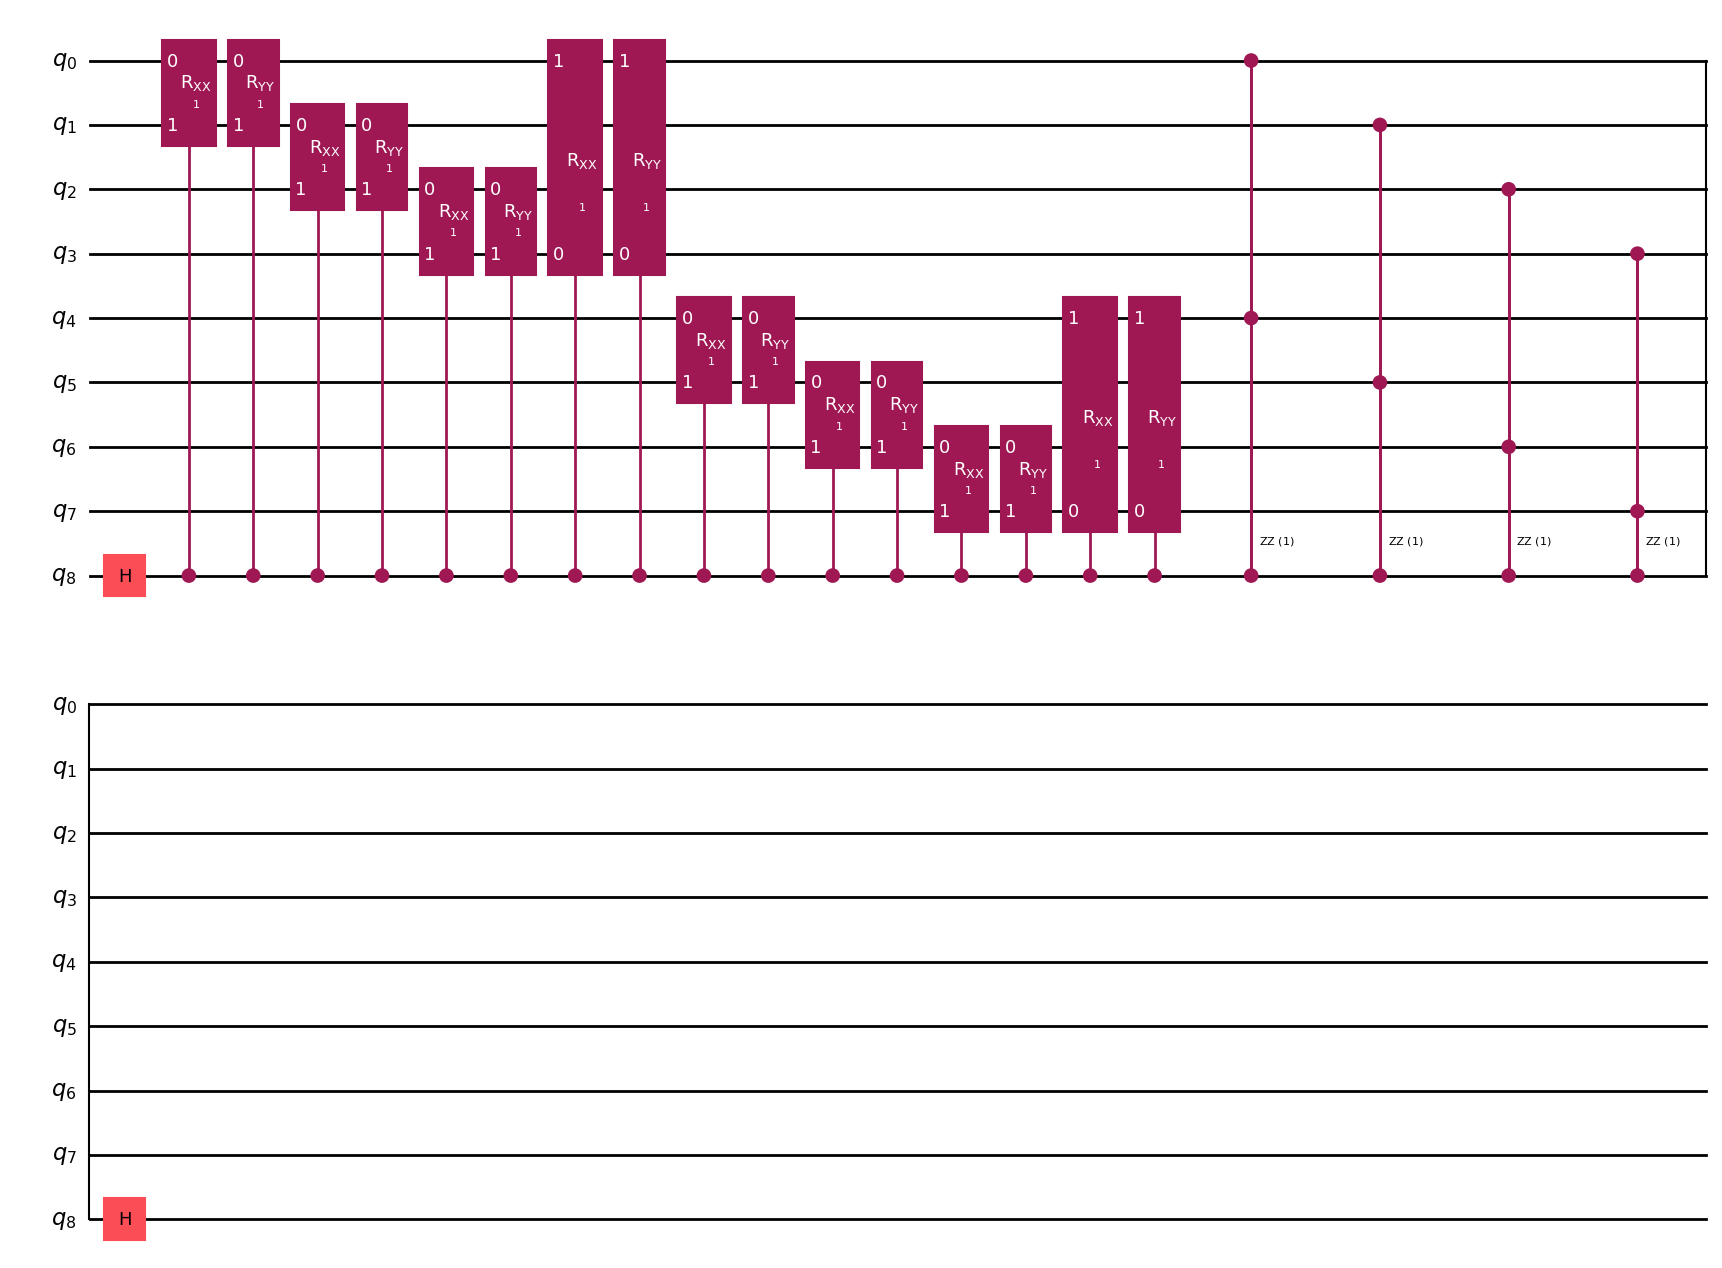

In [6]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import RXXGate, RYYGate, RZZGate

def controlled_XX_YY(qc, ancilla, q1, q2, t):
    """Applies controlled-RXX and controlled-RYY gates."""
    qc.append(RXXGate(2*t).control(1), [ancilla, q1, q2])
    qc.append(RYYGate(2*t).control(1), [ancilla, q1, q2])

def controlled_ZZ(qc, ancilla, q1, q2, t):
    """Applies controlled-RZZ gate."""
    qc.append(RZZGate(2*t).control(1), [ancilla, q1, q2])

N = 4  # Number of qubits per ring
qc = QuantumCircuit(2 * N + 1)  # Extra qubit for the ancilla

ancilla = 2 * N  # The last qubit is the ancilla

# Initialize ancilla in |+> state for potential applications
qc.h(ancilla)

# First ring: controlled XX + YY interactions
for i in range(N):
    controlled_XX_YY(qc, ancilla, i, (i+1) % N, t=0.5)

# Second ring: controlled XX + YY interactions
for i in range(N):
    controlled_XX_YY(qc, ancilla, i + N, (i+1) % N + N, t=0.5)

# Inter-ring controlled ZZ interactions
for i in range(N):
    controlled_ZZ(qc, ancilla, i, i + N, t=0.5)

# Apply Hadamard to ancilla again if using phase estimation
qc.h(ancilla)

qc.draw('mpl')


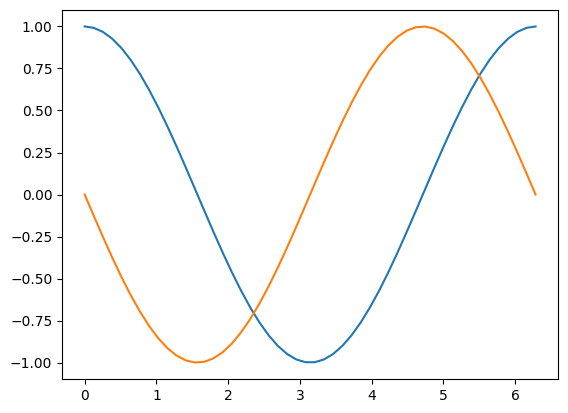

In [12]:
from numpy import exp, linspace, pi
import matplotlib.pyplot as plt
x = linspace(0, 2*pi)
result = exp(-1j*x)

plt.plot(x, result.real)
plt.plot(x, result.imag)